# Clasificación por Espacios Curriculares con Pocos Registros
Este notebook entrena un modelo de Regresión Logística para cada espacio curricular con menos de 100 registros.

In [7]:
# Importar las librerias necesarias. Como pandas para trabajar con el dataset, numpy paara los calculos numericos,
Sklearn, como herramientas del aprendizaje automático, en la division de los datos, modelo, preprocesameinto y métricas, y,
matplotlib y seaborn, para la visualización de los resultados.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report,confusion_matrix 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Cargar dataset limpio, desde un archivos CSV
df = pd.read_csv('C:/Users/Usuario/OneDrive/Documentos/BASE_DE_DATOS_E_INTELIGENCIA_ARTIFICIAL/2025/APRENDIZAJE AUTOMATICO (2A1C)/PARCIAL/Clasificacion_Asignacion_DocentesTDF/data/processed/dataset_docentes_etl.csv')

In [9]:
# Filtrar columnas necesarias, y verificamos que no existan valores nulos.
df = df[['titulo', 'nombre', 'desc_espacio', 'caracter']].dropna()

In [10]:
# Contar la cantidad de Espacios curriculares e identificar aquellos con menos de 100 registros. 
# Estos resgistros a considerar son pocos comunes y para los que se entrenará un modelo individualemente.
espacio_counts = df['desc_espacio'].value_counts()
espacios_pocos = espacio_counts[espacio_counts < 100].index.tolist()
print(f'Se encontraron {len(espacios_pocos)} espacios curriculares con menos de 100 registros.')
espacios_pocos[:10]

Se encontraron 349 espacios curriculares con menos de 100 registros.


['ELECTRÓNICA',
 'RELACIONES PÚBLICAS',
 'QUÍMICA - QUÍMICA I',
 'QUÍMICA II - III',
 'A.T.T.P. INFORMÁTICA',
 'ADMINISTRACIÓN PÚBLICA',
 'PROCESOS TECNOLÓGICOS: MÓDULO - TALLER DE RELACIONES ECONÓMICAS',
 'A.T.T.P. COMPUTACIÓN',
 'PROCESOS TECNOLÓGICOS: MÓDULO - TALLER DE PROCESAMIENTO DE DATOS',
 'QUÍMICA INORGÁNICA']

In [11]:
# Iterar a través de cada uno de los espacios curriculares con pocos registros, 
# y creándose un subconjuntos de datos que solo contiene las filas de ese espacio 
# y asi luego proceder con los pasos del entrenamiento del modelo de Regresión Logística

resultados = []
matrices_confusion = {} # Diccionario para almacenar las matrices de confusión

for espacio in espacios_pocos:
    subset = df[df['desc_espacio'] == espacio]
    clases_validas_en_subset = subset['caracter'].value_counts()
    clases_validas_en_subset = clases_validas_en_subset[clases_validas_en_subset >= 2].index
    subset_filtrado = subset[subset['caracter'].isin(clases_validas_en_subset)]
    
    if len(subset_filtrado) < 10:
        continue
    
    X = subset_filtrado[['titulo', 'nombre']]
    y = subset_filtrado['caracter']
    
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_encoded = encoder.fit_transform(X)
    
    # División estratificada solo si hay al menos 2 clases con más de un ejemplo
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_encoded, y, test_size=0.3, stratify=y, random_state=42
        )
    except ValueError as e:
        continue  # pasa si hay un problema con las clases
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_macro = report['macro avg']['f1-score']

    # Generar la Matriz de Confusión 
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    matrices_confusion[espacio] = {'cm': cm, 'labels': model.classes_}

    # Almacenar los Resultados: La precisión y la F1-macro, junto con el número de registros y clases, se añaden a la lista resultados.
    resultados.append({
        'espacio': espacio,
        'n_registros': len(subset),
        'accuracy': round(accuracy, 3),
        'f1_macro': round(f1_macro, 3),
        'n_clases': subset['caracter'].nunique()
    })

In [12]:
# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)
df_resultados_ordenados = df_resultados.sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
print("\nResultados de Modelos por Espacio Curricular:")
print(df_resultados_ordenados.head()) 


Resultados de Modelos por Espacio Curricular:
                                             espacio  n_registros  accuracy  \
0  PROYECTO FINAL (B. ESP. EN DANZA DE ORIGEN ESC...           10       1.0   
1                                      DANZA CLÁSICA           10       1.0   
2                CIRCUITOS ELÉCTRICOS Y REDES I - II           15       1.0   
3                        PRODUCCIÓN ANIMAL (PORCINO)           16       1.0   
4                                      AUDIOCREATIVA           16       1.0   

   f1_macro  n_clases  
0       1.0         2  
1       1.0         2  
2       1.0         3  
3       1.0         2  
4       1.0         3  


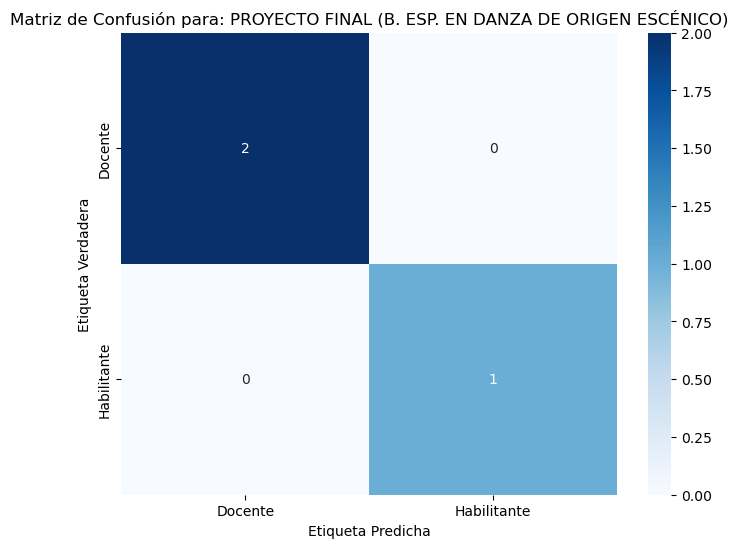

In [13]:
# Visualizar la Matriz de Confusión para un espacio específico 
# Se Puede elegir un espacio de df_resultados_ordenados, por ejemplo, el que tiene el mejor F1-macro
espacio_ejemplo = df_resultados_ordenados.iloc[0]['espacio'] # El mejor espacio

if espacio_ejemplo in matrices_confusion:
    cm_data = matrices_confusion[espacio_ejemplo]['cm']
    cm_labels = matrices_confusion[espacio_ejemplo]['labels']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues',
                xticklabels=cm_labels, yticklabels=cm_labels)
    plt.title(f'Matriz de Confusión para: {espacio_ejemplo}')
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Verdadera')
    plt.show()
else:
    print(f"No se encontró la matriz de confusión para '{espacio_ejemplo}'.")

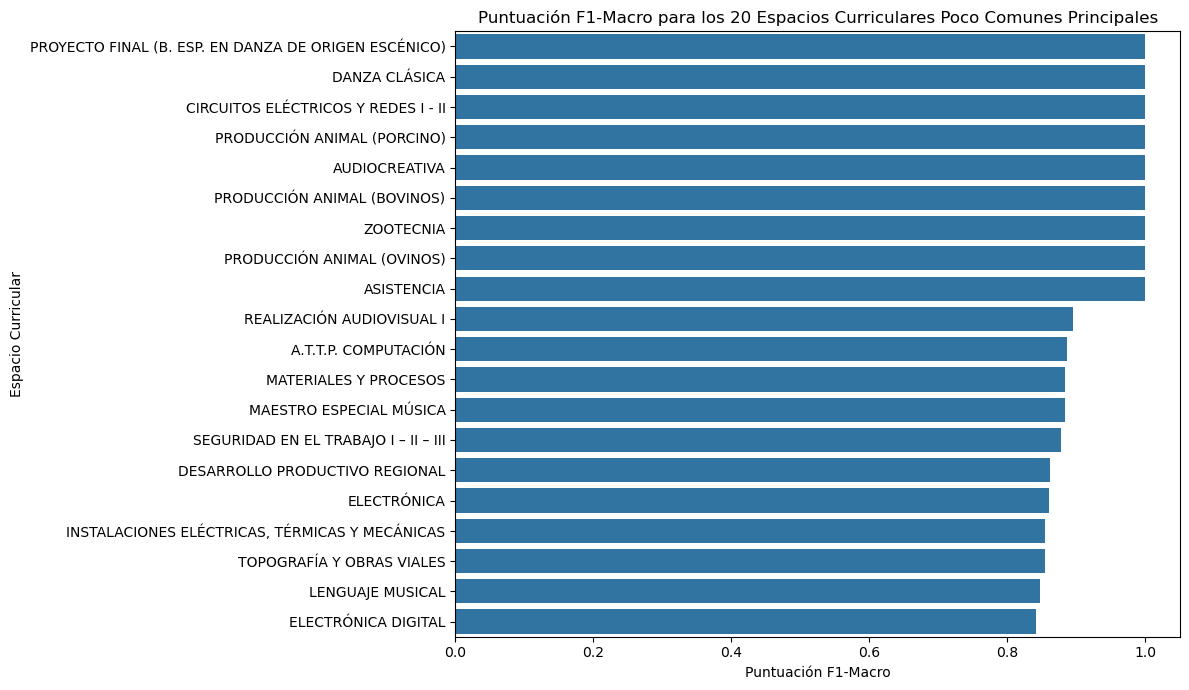

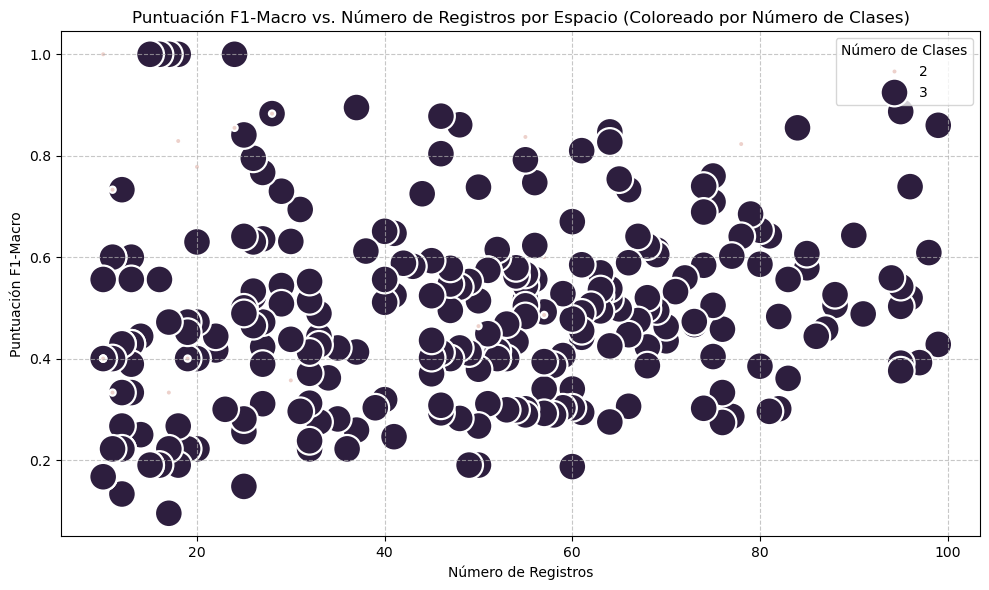

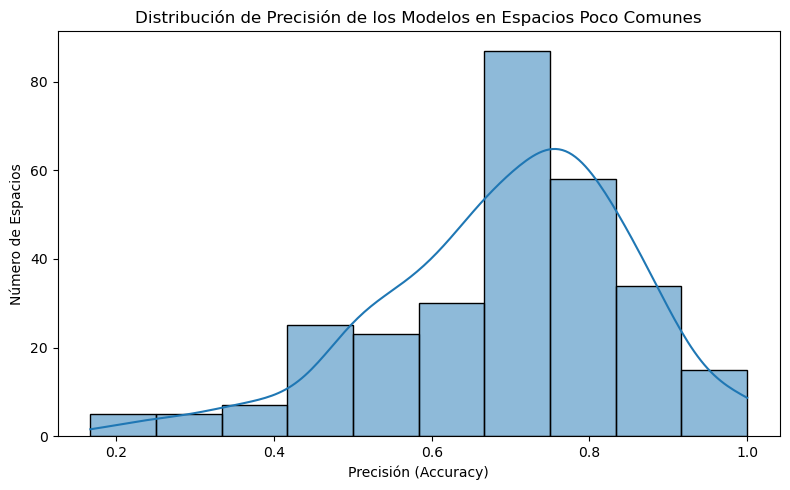

In [14]:
# --- Ejemplo: Gráfico de Barras de Puntuaciones F1-Macro (Top N) ---
plt.figure(figsize=(12, 7))
# Mostramos los 20 espacios principales para no sobrecargar el gráfico
sns.barplot(x='f1_macro', y='espacio', data=df_resultados.sort_values(by='f1_macro', ascending=False).head(20))
plt.title('Puntuación F1-Macro para los 20 Espacios Curriculares Poco Comunes Principales')
plt.xlabel('Puntuación F1-Macro')
plt.ylabel('Espacio Curricular')
plt.tight_layout() # Ajusta automáticamente los parámetros de la subtrama para un diseño ajustado.
plt.show()

# --- Ejemplo: Gráfico de Dispersión: F1-Macro vs. Número de Registros ---
plt.figure(figsize=(10, 6))
# 'hue' y 'size' pueden ayudar a visualizar la relación con el número de clases
sns.scatterplot(x='n_registros', y='f1_macro', hue='n_clases', size='n_clases', sizes=(20, 400), data=df_resultados)
plt.title('Puntuación F1-Macro vs. Número de Registros por Espacio (Coloreado por Número de Clases)')
plt.xlabel('Número de Registros')
plt.ylabel('Puntuación F1-Macro')
plt.grid(True, linestyle='--', alpha=0.7) # Añade una cuadrícula para mejor legibilidad
plt.legend(title='Número de Clases')
plt.tight_layout()
plt.show()

# --- Ejemplo: Distribución de Accuracies (Histograma) ---
plt.figure(figsize=(8, 5))
sns.histplot(df_resultados['accuracy'], bins=10, kde=True) # kde=True añade una estimación de densidad de kernel
plt.title('Distribución de Precisión de los Modelos en Espacios Poco Comunes')
plt.xlabel('Precisión (Accuracy)')
plt.ylabel('Número de Espacios')
plt.tight_layout()
plt.show()